In [6]:
# ============================================================
# Assignment: Manual LSTM Cell for MNIST Digit Classification
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
# ============================================================
# Hyperparameters - you may change the parameter to get the better accuracy
# ============================================================
input_size = 28
hidden_size = 32
num_layers = 1
num_classes = 10
batch_size = 128
learning_rate = 0.00006
num_epochs = 50

In [8]:
# ============================================================
# Load the MNIST Dataset
# ============================================================

train_dataset = torchvision.datasets.MNIST(
root='./data',
train=True,
transform=transforms.ToTensor(),
download=True
)

test_dataset = torchvision.datasets.MNIST(
root='./data',
train=False,
transform=transforms.ToTensor(),
download=True
)

train_loader = torch.utils.data.DataLoader(
dataset=train_dataset,
batch_size=batch_size,
shuffle=True
)

test_loader = torch.utils.data.DataLoader(
dataset=test_dataset,
batch_size=batch_size,
shuffle=False
)

In [9]:
# ============================================================
# TODO 1 : Build Manual LSTM Cell
# ============================================================
class ManualLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ManualLSTMCell, self).__init__()
        # TODO: Define weight matrices for
        # - Forget gate (Weight f)
        # - Input gate (Weight i)
        # - Output gate (Weight o)
        # - Candidate cell (Weight c)

        concat_size = input_size + hidden_size
        self.W_f = nn.Linear(concat_size, hidden_size)
        self.W_i = nn.Linear(concat_size, hidden_size)
        self.W_o = nn.Linear(concat_size, hidden_size)
        self.W_c = nn.Linear(concat_size, hidden_size)

        
    def forward(self, x, h_prev, c_prev):
        # TODO:
        # 1. Concatenate input x and previous hidden state h_prev
        # 2. Calculate forget gate f_t
        # 3. Calculate input gate i_t
        # 4. Calculate candidate cell state c_tilde
        # 5. Update cell state c_t
        # 6. Calculate output gate ot
        # 7. Update hidden state h_t
        # HINT: use torch.sigmoid and torch.tanh
        
        combined = torch.cat((x, h_prev), dim=1)

        f_t = torch.sigmoid(self.W_f(combined))
        i_t = torch.sigmoid(self.W_i(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        c_tilde = torch.tanh(self.W_c(combined))

        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t
    
    # Full LSTM network
class ManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(ManualLSTMClassifier, self).__init__()
        # TODO: Create ManualLSTMCell
        # TODO: Create fully connected layer
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.cells = nn.ModuleList()
        self.cells.append(ManualLSTMCell(input_size, hidden_size))
        
        for _ in range(1, num_layers):
            self.cells.append(ManualLSTMCell(hidden_size, hidden_size))
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # TODO:
        # 1. Initialize h_t and c_t to zeros
        # 2. Unroll through the sequence (for each time step)
        # 3. Update h_t and c_t at each time step
        # 4. Pass last h_t into fully connected layer
        
        batch_size, seq_len, _ = x.size()
        device = x.device

        h_t = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.cells[layer](x_t, h_t[layer], c_t[layer])
                x_t = h_t[layer]

        out = self.fc(h_t[-1])
        return out

In [10]:
# ============================================================
# Training and Testing - #You are allowed to change the optimizer
# ============================================================
# Define model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ManualLSTMClassifier(input_size, hidden_size, num_classes, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Logging
train_loss_hist, test_loss_hist = [], []
train_acc_hist,  test_acc_hist  = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_total   += labels.size(0)
        running_correct += (preds == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = 100 * running_correct / running_total
    train_loss_hist.append(epoch_train_loss)
    train_acc_hist.append(epoch_train_acc)
    
    # TODO 2: Testing loop to print the accuracy
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28, 28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_loss = test_loss / total
    epoch_test_acc  = 100 * correct / total
    test_loss_hist.append(epoch_test_loss)
    test_acc_hist.append(epoch_test_acc)
    
    print(f'>>> Epoch [{epoch+1}/{num_epochs}]  'f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%  'f'|| Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%')

Epoch [1/50], Step [100/469], Loss: 2.3095
Epoch [1/50], Step [200/469], Loss: 2.2907
Epoch [1/50], Step [300/469], Loss: 2.2956
Epoch [1/50], Step [400/469], Loss: 2.2848
>>> Epoch [1/50]  Train Loss: 2.3011 | Train Acc: 10.32%  || Test Loss: 2.2917 | Test Acc: 10.27%
Epoch [2/50], Step [100/469], Loss: 2.2944
Epoch [2/50], Step [200/469], Loss: 2.2523
Epoch [2/50], Step [300/469], Loss: 2.1601
Epoch [2/50], Step [400/469], Loss: 2.0573
>>> Epoch [2/50]  Train Loss: 2.1820 | Train Acc: 20.71%  || Test Loss: 1.9319 | Test Acc: 36.46%
Epoch [3/50], Step [100/469], Loss: 1.7662
Epoch [3/50], Step [200/469], Loss: 1.7138
Epoch [3/50], Step [300/469], Loss: 1.6212
Epoch [3/50], Step [400/469], Loss: 1.5028
>>> Epoch [3/50]  Train Loss: 1.6895 | Train Acc: 47.80%  || Test Loss: 1.5194 | Test Acc: 53.99%
Epoch [4/50], Step [100/469], Loss: 1.5216
Epoch [4/50], Step [200/469], Loss: 1.3944
Epoch [4/50], Step [300/469], Loss: 1.4687
Epoch [4/50], Step [400/469], Loss: 1.2942
>>> Epoch [4/50]  

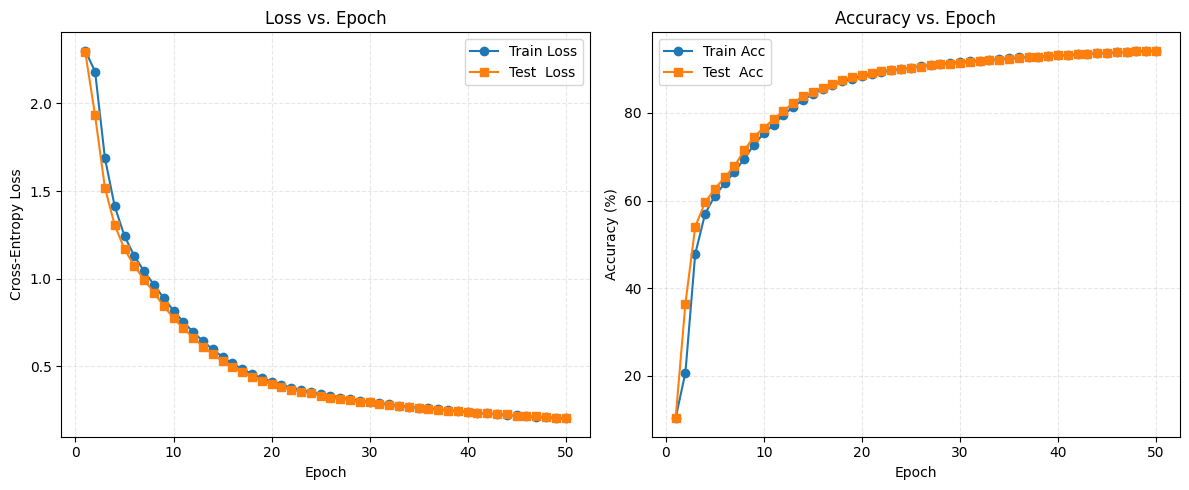

In [11]:
# ============================================================
# TODO 3: Visualization prediction
# Print the accuracy from test_data
# Show 10 example images including true label and prediction
# ============================================================

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, marker='o', label='Train Loss')
plt.plot(epochs, test_loss_hist,  marker='s', label='Test  Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, marker='o', label='Train Acc')
plt.plot(epochs, test_acc_hist,  marker='s', label='Test  Acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Final Test Accuracy: 96.09%


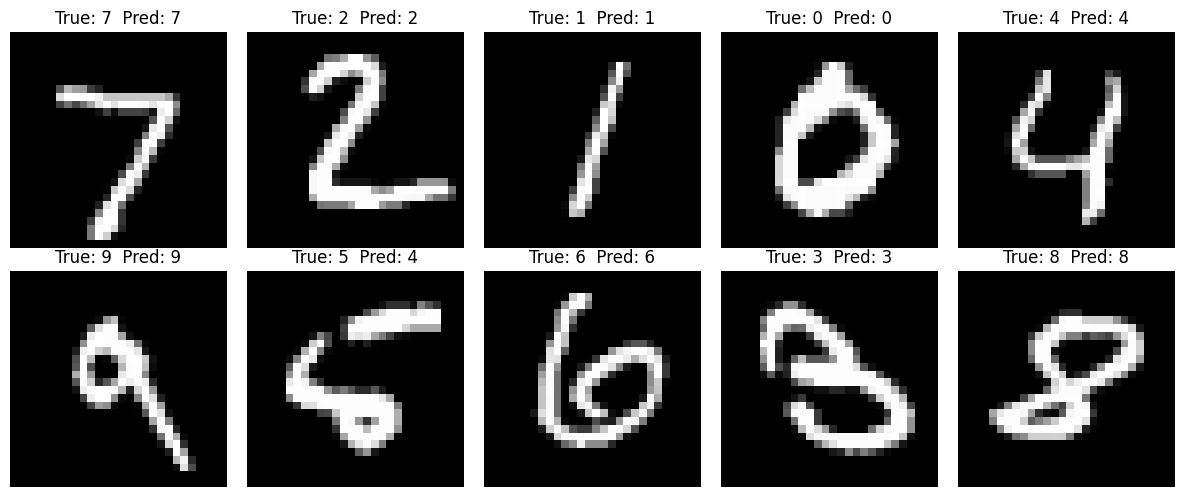

In [12]:
model.eval()
correct, total = 0, 0
example_imgs, example_preds, example_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # digits 0–9
        for img, lbl, pred in zip(images.cpu(), labels.cpu(), predicted.cpu()):
            if len(example_imgs) == 10:
                break
            # keep at most one sample per ground-truth digit for clarity
            if lbl.item() not in [l.item() for l in example_labels]:
                example_imgs.append(img)
                example_labels.append(lbl)
                example_preds.append(pred)
        if len(example_imgs) == 10:
            break

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')

# Visualize 10 examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    img = example_imgs[idx].numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {example_labels[idx].item()}  '
                 f'Pred: {example_preds[idx].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Epoch [1/50], Step [100/469], Loss: 2.2994
Epoch [1/50], Step [200/469], Loss: 2.1549
Epoch [1/50], Step [300/469], Loss: 1.8010
Epoch [1/50], Step [400/469], Loss: 1.1729
>>> Epoch [1/50]  Train Loss: 1.8285 | Train Acc: 33.97%  || Test Loss: 0.9395 | Test Acc: 69.37%
Epoch [2/50], Step [100/469], Loss: 0.8601
Epoch [2/50], Step [200/469], Loss: 0.8276
Epoch [2/50], Step [300/469], Loss: 0.6787
Epoch [2/50], Step [400/469], Loss: 0.5600
>>> Epoch [2/50]  Train Loss: 0.6769 | Train Acc: 79.19%  || Test Loss: 0.4822 | Test Acc: 86.22%
Epoch [3/50], Step [100/469], Loss: 0.5810
Epoch [3/50], Step [200/469], Loss: 0.5668
Epoch [3/50], Step [300/469], Loss: 0.4923
Epoch [3/50], Step [400/469], Loss: 0.3672
>>> Epoch [3/50]  Train Loss: 0.4159 | Train Acc: 87.95%  || Test Loss: 0.3365 | Test Acc: 90.28%
Epoch [4/50], Step [100/469], Loss: 0.3568
Epoch [4/50], Step [200/469], Loss: 0.3450
Epoch [4/50], Step [300/469], Loss: 0.2427
Epoch [4/50], Step [400/469], Loss: 0.2649
>>> Epoch [4/50]  

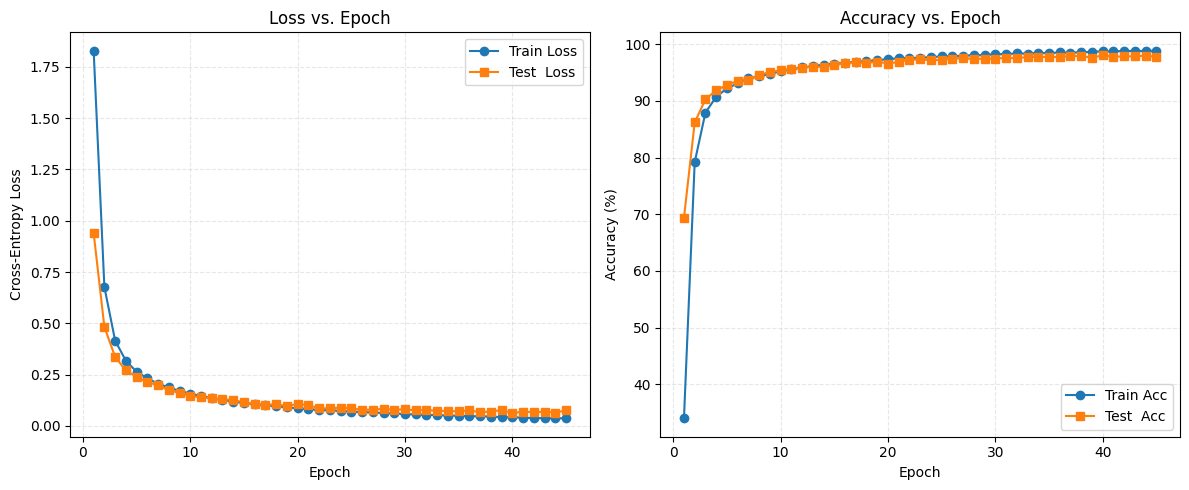

Final Test Accuracy: 99.22%


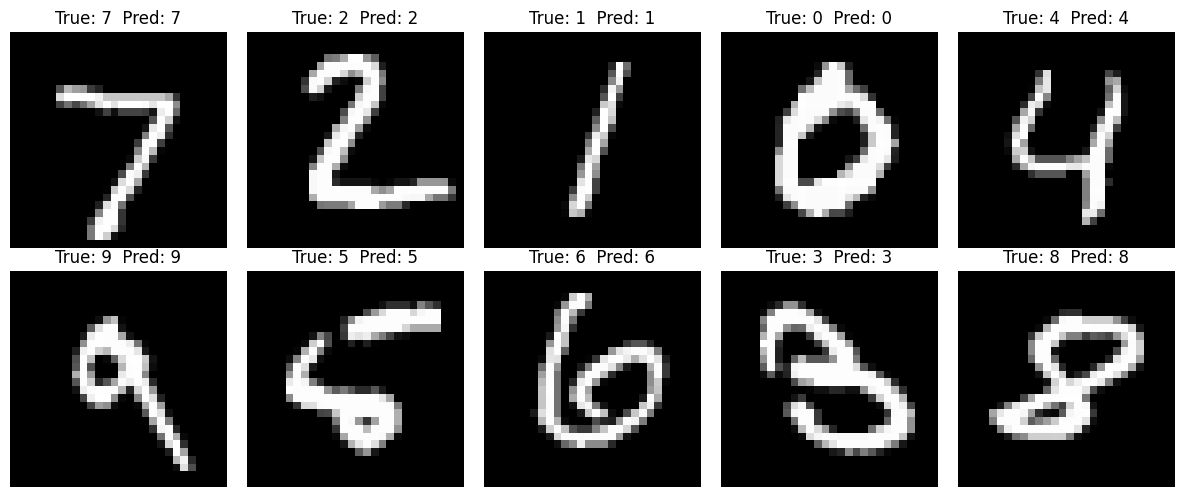

In [14]:
# ============================================================
# Hyperparameters - you may change the parameter to get the better accuracy
# ============================================================
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 128
learning_rate = 0.00006
num_epochs = 50

# ============================================================
# Training and Testing - #You are allowed to change the optimizer
# ============================================================
# Define model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ManualLSTMClassifier(input_size, hidden_size, num_classes, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Logging
train_loss_hist, test_loss_hist = [], []
train_acc_hist,  test_acc_hist  = [], []

# Early Stopping Parameters
patience = 5
best_test_loss = float('inf')
early_stop_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_total   += labels.size(0)
        running_correct += (preds == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = 100 * running_correct / running_total
    train_loss_hist.append(epoch_train_loss)
    train_acc_hist.append(epoch_train_acc)
    
    # TODO 2: Testing loop to print the accuracy
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28, 28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_loss = test_loss / total
    epoch_test_acc  = 100 * correct / total
    test_loss_hist.append(epoch_test_loss)
    test_acc_hist.append(epoch_test_acc)
    
    print(f'>>> Epoch [{epoch+1}/{num_epochs}]  'f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%  'f'|| Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%')
    
    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}")
        break
    
# ============================================================
# TODO 3: Visualization prediction
# Print the accuracy from test_data
# Show 10 example images including true label and prediction
# ============================================================

epochs = range(1, len(train_loss_hist) + 1)
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, marker='o', label='Train Loss')
plt.plot(epochs, test_loss_hist,  marker='s', label='Test  Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, marker='o', label='Train Acc')
plt.plot(epochs, test_acc_hist,  marker='s', label='Test  Acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct, total = 0, 0
example_imgs, example_preds, example_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # digits 0–9
        for img, lbl, pred in zip(images.cpu(), labels.cpu(), predicted.cpu()):
            if len(example_imgs) == 10:
                break
            # keep at most one sample per ground-truth digit for clarity
            if lbl.item() not in [l.item() for l in example_labels]:
                example_imgs.append(img)
                example_labels.append(lbl)
                example_preds.append(pred)
        if len(example_imgs) == 10:
            break

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')

# Visualize 10 examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    img = example_imgs[idx].numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {example_labels[idx].item()}  '
                 f'Pred: {example_preds[idx].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()